In [59]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import load_sample_image
%matplotlib inline

from functools import partial

In [7]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")
    
def crop(images):
    return images[150:220, 130:250]

# Convolutional Neural Network - CNN

CNN sono emerse dagli studi sulla corteccia visiva del cervello ed utilizzate in problema di image recognition dal 1980. Negli ultimi anni hanno raggiunto performance addirittura migliori del gold standard dato dalle prestazioni umane. Ad giorno d'oggi sono utilizzate anche in altri contesti come voice recognition (Alexa, Siri, Google Assistant, etc..) o natural language processing. 

L'ispirazione fornita dalla struttura della corteccia visiva deriva dall'osservazione che molti neuroni della corteccia reagiscono solo a stimoli visivi limitati ad un piccola porzione della campo visivo, come mostrato in figura:

![](cnn_1.png)

Inoltre altri neuroni reagiscono solo a determinati pattern di attivazioni: line orizzontali, verticali o oblique; oppure agiscono su regioni del campo visivo più estese combinando pattern semplici in pattern più complessi.

Tale struttura ha ispirato il primo esemplare di CNN, sviluppato da LeCun nel 1998. Tale architettura ha introdotto due nuovi tipi di layer:
- convolutional layer
- pooling layer

## Convolutional Layer
In questo layer, le unità di attivazione non sono collegate ad ogni unità di input, ma solo alle unità di input appartenenti alla regione di ricezione. Un esempio di questa diversa architettura del livello è mostrata nella figura:

![](cnn_2.png)

Tramite questa struttura piramidale, nei primi livelli vengono rappresentate le caratteristiche di basso livello, mentre eni livelli superiori si compongono tali caratteristiche in caratteristiche più complesse. 

Dal punto di vista della rappresentazione, a differenza dei dense layer, ogni livello è rappresentato in 2D o 3D, come vedremo in seguito.

Nello specifico un'unità in posizione $i,j$ in un CNN layer è connesso all'output delle unità del livello sottostante comprese tra le righe $i$ e $i+\mathbf{f_h} -1$ e le colonne $j$ e $j+\mathbf{f_w} -1$, dove $i$ e $\mathbf{f_w}$ e $\mathbf{f_h}$ rappresentano l'altezza e la lunghezza del campo recettivo. Al fine di mantenere la stessa dimensione tra i livelli si è soliti aggiungere degli 0 attorno al livello = **zero padding**.

![](cnn_3.png)

E' possibile anche ridurre la dimensione del livello facendo compiere dei salti al campo recettivo. La lunghezza del "salto" viene indicata dal parametro **stride**. In qeusto modo si riduce la complessità del modello. Formalmente un'unità in posizione $i,j$ in un CNN layer è connesso all'output delle unità del livello sottostante comprese tra le righe $i*\mathbf{s_h}$ e $i*\mathbf{s_h}+\mathbf{f_h} -1$ e le colonne $j*\mathbf{s_w}$ e $j*\mathbf{s_w}+\mathbf{f_w} -1$, dove $\mathbf{s_w}$ e $\mathbf{s_h}$ rappresentano gli stride orizzontali e verticali

I precedenti concetti sono riportati nella seguente figura:
![](cnn_4.png)

### Filters
I pesi dei neuroni che finiscono il campo recettivo formano una piccola immagine che da ora definiamo come **filter** o **convolutional kernel**.

Utilizziamo un filtro che evidenzia gli elementi verticali e un filtro che evidenzia quelli orizzontalii.

In [6]:
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

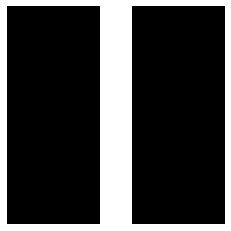

In [14]:
plot_image(filters[:, :, 0, 0])

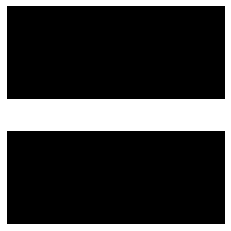

In [15]:
plot_image(filters[:, :, 0, 1])

In [10]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

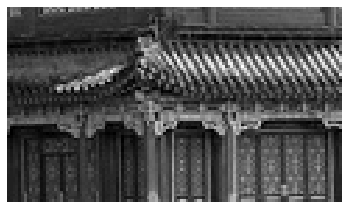

In [11]:
plot_image(crop(images[0, :, :, 0]))

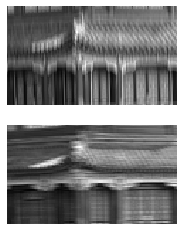

In [13]:
for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plt.subplot(2,1,feature_map_index + 1)
    plot_image(crop(outputs[0, :, :, feature_map_index]))

L'applicazione dello stesso filtro al livello di input genera un nuovo layer chiamato **feature map**. Una feature map è il risultato dell'applicazione dello stesso filtro su tutto il layer e identifica le aree che attivano in maniera più significativa il filtro. 

L'obiettivo del processo di training è apprendere i filtri più "utili" per il task e i layer successivi imparano come combinare i filtri appresi al livello precedente per identificare pattern più complessi.

I layer CNN sono caratterizzati da più filtri, ognuno dei quali produce una feature map diversa. Di consequenza, è corretto rappresentare un convolutional layer mediante un tensore 3D.

Nel caso delle immagini anche il livello di output è un tensore 3D in quanto ci sono 3 canali - RGB - per ogni pixel. 

![](cnn_5.png)

In generale il valore di un'unità $z_{i,j,k}$ è definito dalla seguente equazione:

![](cnn_6.png)

In TF, un'immagine è un tensore 3D, mentre i pesi dei filtri sono un tensore 4D $f_h\times f_w\times f_{n'}\times f_{n}$ 


In generale il parametro *stride* accetta anche una quadrupla in cui gli elementi centrali specificano gli stride orizzontali e verticali. Per quanto riguarda il parametro *padding*, esso può assumere due valori:
- **SAME**: viene utilizzato lo zero padding quando necessario. Quando stride=1 vengono mantenute le dimensioni del livello precedente.
- **VALID**: non viene utilizzato lo zero padding.

![](cnn_7.png)

I precedenti parametri rappresentano gli iperparametri del singolo convolutional layer. 


## Pooling Layer
Un pooling layer riduce il carico computazionale, l'utilizzo di memoria ed il numero di parametri. Ogni unità in un pooling layer è connesso all'output di un numero di unità limitate del livello precedente. L'idea è simile al filtro in un convolutional layer ma non esistono pesi da apprendere, ma aggrega i valori in ingresso utilizzando una funzione di aggregazione come il massimo o la media. 

![](cnn_8.png)

In TF un **max pooling layer** si definisce nel seguente modo, mediante la classe **MaxPool2D**:

In [34]:
max_pool = keras.layers.MaxPool2D(pool_size=2, strides = 2)

In [35]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

(70, 120, 3) (35, 60, 3)


(-0.5, 59.5, 34.5, -0.5)

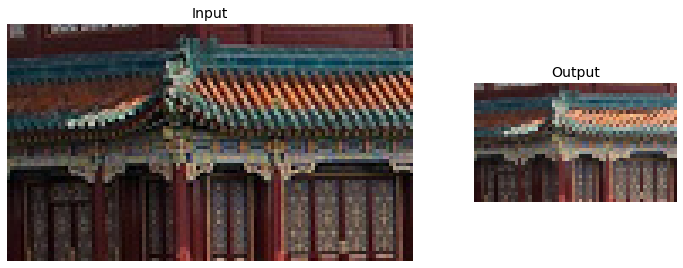

In [36]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  #esito max pooling
print(cropped_images[0].shape, output[0].shape)
ax2.axis("off")

Mentre un **average pooling** viene implementato dalla classe **AvgPool2D**

(70, 120, 3) (35, 60, 3)


(-0.5, 59.5, 34.5, -0.5)

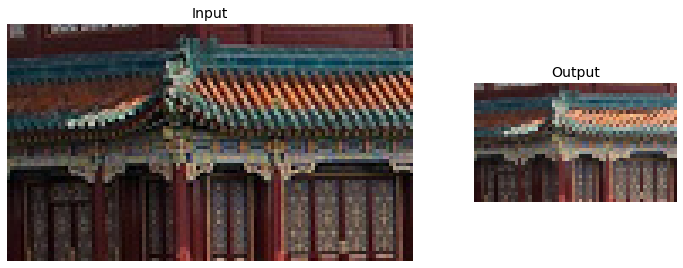

In [37]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  #esito max pooling
print(cropped_images[0].shape, output[0].shape)
ax2.axis("off")

Un ulteriore pooling layer è il **global average pooling layer** che restituisce la media di tutte le unità di una feature map. Solitamente viene utilizzato come layer di output.

In [38]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

## CNN Architectures
Tipicamente le architetture CNN impilano alcuni layer convoluzionali seguiti da un pooling layer, in modo iterativo. Al termine della sequenza di questi livelli  viene inserita una rete feedforward composta da alcuni hidden layer. Un tipico esempio di questa architettura è mostrato nella seguente figura:

![](cnn_9.png)

E' inoltre consigliato definire dei filtri di piccole dimensioni e mettere in sequenza più layer con filtri di piccole dimensione rispetto a creare un singolo layer con un filtro di dimensioni più elevate. L'unica eccezione è il layer convoluzionale vicino al layer di input. In questo caso si usano una serie di filtri di dimensione 7x7 con stride 2, in modo da ridurre le dimensioni spaziali dell'immagine.

Nel caso del dataset Fashion MNIST, applichiamo un modello che segue la struttura mostrata in precedenza.

In [39]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

Definiamo il modello

In [41]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1], padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
#     keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
#     keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [42]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)
print(score)

Epoch 1/10
1719/1719 [==============================] - 188s 110ms/step - loss: 0.4427 - accuracy: 0.8402 - val_loss: 0.3144 - val_accuracy: 0.8834
Epoch 2/10
1719/1719 [==============================] - 191s 111ms/step - loss: 0.2832 - accuracy: 0.8947 - val_loss: 0.3071 - val_accuracy: 0.8904
Epoch 3/10
1719/1719 [==============================] - 193s 112ms/step - loss: 0.2423 - accuracy: 0.9087 - val_loss: 0.2724 - val_accuracy: 0.8968
Epoch 4/10
1719/1719 [==============================] - 198s 115ms/step - loss: 0.2122 - accuracy: 0.9211 - val_loss: 0.2817 - val_accuracy: 0.8962
Epoch 5/10
1719/1719 [==============================] - 197s 115ms/step - loss: 0.1897 - accuracy: 0.9290 - val_loss: 0.2954 - val_accuracy: 0.8986
Epoch 6/10
1719/1719 [==============================] - 196s 114ms/step - loss: 0.1729 - accuracy: 0.9342 - val_loss: 0.2651 - val_accuracy: 0.9056
Epoch 7/10
1719/1719 [==============================] - 199s 116ms/step - loss: 0.1534 - accuracy: 0.9423 - val_

### LeNet-5
E' l'architettura piu' conosciuta e la prima ad ottenere delle buone performance. La struttura dell'archittetura e' la seguente:

![](cnn_10.png)

Rispetto all'originale, si preferisce utilizzare la cross-entropy.

### AlexNet
E' simile a LeNet-5 ma ha un'architettura piu' profonda -deep. Inoltre vengono impilati per la prima volta piu' layer convoluzionali non intervallati da pooling layer.

![](cnn_11.png)

Nella fase di training gli autori hanno utilizzati anche tecniche di **data augmentation**, in cui si aumenta la dimensione del training set aggiungendo della varianti realistiche delle immagini di training, applicando una serie di trasformazioni quali:
- spostamenti
- rotazioni
- riflessioni verticali/ orizzontali
- zoom in
- luminosita'

Questo introduce un certo elemento di robustezza alle piccole variazioni delle immagini.

![](cnn_11b.png)

In Keras possiamo introdurre dei livelli di data augmentation mediante alcune classi rese disponibili nel package **preprocessing.experimental**.

In [44]:
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Inoltre dopo il calcolo della ReLU in C1 e C3 viene applicata una tecnica di **local response normalization** in cui l'unita' piu' attiva inibisce le altre unita' nelle feature map adiacenti.

![](cnn_12.png)

### ResNet
ResNet e' un'architettura estremamente profonda composta da 152 layers. Vengono inoltre inserite delle **skip connection**: l'output di un livello viene aggiungto all'output di un altro livello posizionato piu' in "alto" nell'architettura.

![](cnn_14.png)

Aggiungendo le skip connection la rete puo' apprendere nonostante alcuni moduli, detti **residual unit** non abbiano ancora imparato. Ricordiamo che imparare vuol dire aggiornare i pesi. 

![](cnn_15.png)


L'architettura complessiva e' una sequenza di residual unit. Nello specifico ogni residual unit e' formata da due layer convoluzionali che filtri 3x3, stride 1 e padding 'same'.

![](cnn_16.png)

Possiamo implementare ResNet-34 in Keras:

In [66]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding="SAME", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding="SAME", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding="SAME", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [74]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, padding="SAME", use_bias=False, input_shape=[28, 28, 1]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [75]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_299 (Conv2D)          (None, 14, 14, 64)        3136      
_________________________________________________________________
batch_normalization_294 (Bat (None, 14, 14, 64)        256       
_________________________________________________________________
activation_15 (Activation)   (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
residual_unit_128 (ResidualU (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_129 (ResidualU (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_130 (ResidualU (None, 7, 7, 64)        

In [76]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)
print(score)

Epoch 1/2
  78/1719 [>.............................] - ETA: 26:41 - loss: 1.3172 - accuracy: 0.6186

KeyboardInterrupt: 

Solitamente non dobbiamo implementare le architetture standard, dal momento questo genere di reti sono gia' state addestrare e rese disponibili nel package **keras.application**. Possiamo caricare ResNet50 addestrata su ImageNet.

In [77]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 9s 0us/step


ResNet50 richiede immagini 224 x 224. Per modificare la dimensione di un'immagine possiamo utilizzare **tf.image.resize**.

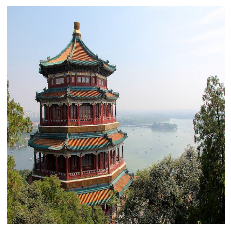

In [78]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])

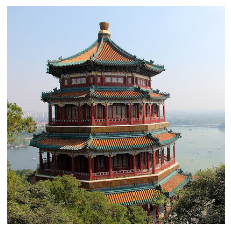

In [81]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])


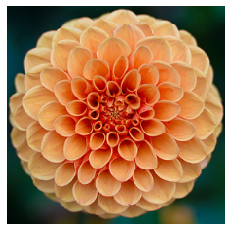

In [80]:
plot_color_image(images_resized[1])

In [82]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [83]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



### Pre-trained model for transfer learning
Spesso si utilizzano i livelli piu' bassi di un'architettura complessa e si modificano quelli piu' vicini all'output per adattare il modello al task obiettivo. Inoltre, posso modificare ulteriormente il modello base considerandolo come 'punto di partenza' per successive epoche di training

In [97]:
base_model = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(5, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [98]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_3
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

I layer del modello base non sono modificabili

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=5)

Adatto i pesi del modello base secondo il nuovo dataset

In [ ]:
for index, layer in enumerate(base_model.layers):
    if index > 150:
        layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=40)